<a href="https://colab.research.google.com/github/jpti89/MM-RAG/blob/main/Google_Gemini_multimodal_rag_DEMO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multimodal Retrieval Augmented Generation (RAG) using Vertex AI Gemini API

| | |
|-|-|
|Original Author | [Lavi Nigam](https://github.com/lavinigam-gcp) |


## Original Source, edited for this project.

<table align="left">
  <td style="text-align: center">
    <a href="https://github.com/GoogleCloudPlatform/generative-ai/blob/main/gemini/use-cases/retrieval-augmented-generation/intro_multimodal_rag.ipynb">
      <img width="32px" src="https://upload.wikimedia.org/wikipedia/commons/9/91/Octicons-mark-github.svg" alt="GitHub logo"><br> View on GitHub
    </a>
  </td>
</table>

### Objectives

This notebook provides a guide to building a document search engine using multimodal retrieval augmented generation (RAG), step by step:

1. Extract and store metadata of documents containing both text and images, and generate embeddings the documents
2. Using a text query as input, search for contexual answers using both text and images

### Install Vertex AI SDK for Python and other dependencies


In [ ]:
! pip3 install --upgrade --user google-cloud-aiplatform pymupdf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.8/30.8 MB 10.8 MB/s eta 0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [ ]:
# Restart kernel after installs so that your environment can access the new packages
import IPython
import time

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

### Authenticate your notebook environment (Colab only)

If you are running this notebook on Google Colab, run the following cell to authenticate your environment. This step is not required if you are using [Vertex AI Workbench](https://cloud.google.com/vertex-ai-workbench).


In [ ]:
import sys

# Additional authentication is required for Google Colab
if "google.colab" in sys.modules:
    # Authenticate user to Google Cloud
    from google.colab import auth

    auth.authenticate_user()

### Define Google Cloud project information


In [ ]:
# Define project information

import sys

PROJECT_ID = "mmragtest"  # @param {type:"string"}
LOCATION = "us-central1"  # @param {type:"string"}

# if not running on colab, try to get the PROJECT_ID automatically
if "google.colab" not in sys.modules:
    import subprocess

    PROJECT_ID = subprocess.check_output(
        ["gcloud", "config", "get-value", "project"], text=True
    ).strip()

print(f"Your project ID is: {PROJECT_ID}")

In [ ]:
import sys

# Initialize Vertex AI
import vertexai

vertexai.init(project=PROJECT_ID, location=LOCATION)

### Import libraries


In [ ]:
from IPython.display import Markdown, display
from vertexai.generative_models import (
    Content,
    GenerationConfig,
    GenerationResponse,
    GenerativeModel,
    HarmCategory,
    HarmBlockThreshold,
    Image,
    Part,
)

### Load the Gemini 1.0 Pro and Gemini 1.0 Pro Vision model


In [ ]:
text_model = GenerativeModel("gemini-1.0-pro")
multimodal_model = GenerativeModel("gemini-1.0-pro-vision")

### Download custom Python modules and utilities

The cell below will download some helper functions needed for this notebook, to improve readability. You can also view the code (`intro_multimodal_rag_utils.py`) directly on [Github](https://raw.githubusercontent.com/GoogleCloudPlatform/generative-ai/main/gemini/use-cases/retrieval-augmented-generation/utils/intro_multimodal_rag_utils.py).

In [ ]:
import os
import urllib.request
import sys

if not os.path.exists("utils"):
    os.makedirs("utils")


# download the helper scripts from utils folder
url_prefix = "https://raw.githubusercontent.com/GoogleCloudPlatform/generative-ai/main/gemini/use-cases/retrieval-augmented-generation/utils/"
files = ["intro_multimodal_rag_utils.py"]

for fname in files:
    urllib.request.urlretrieve(f"{url_prefix}/{fname}", filename=f"utils/{fname}")

#### Get documents and images from GCS

In [ ]:
from utils.intro_multimodal_rag_utils import get_document_metadata

!git clone https://github.com/jpti89/MM-RAG.git

Cloning into 'MM-RAG'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 10 (delta 1), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (10/10), 932.74 KiB | 3.53 MiB/s, done.
Resolving deltas: 100% (1/1), done.


### Extract and store metadata of text and images from a document

In [ ]:
# Specify the PDF folder with multiple PDF

# pdf_folder_path = "/content/data/" # if running in Google Colab/Colab Enterprise
pdf_folder_path = "/content/MM-RAG/PDF Data/"  # if running in Vertex AI Workbench.

# Specify the image description prompt. Change it
image_description_prompt = """Explain what is going on in the image.
If it's a table, extract all elements of the table.
If it's a graph, explain the findings in the graph.
Do not include any numbers that are not mentioned in the image.
"""

# Extract text and image metadata from the PDF document
text_metadata_df, image_metadata_df = get_document_metadata(
    multimodal_model,  # we are passing gemini 1.0 pro vision model
    pdf_folder_path,
    image_save_dir="images",
    image_description_prompt=image_description_prompt,
    embedding_size=1408,
    # add_sleep_after_page = True, # Uncomment this if you are running into API quota issues
    # sleep_time_after_page = 5,
    # generation_config = # see next cell
    # safety_settings =  # see next cell
)

print("\n\n --- Completed processing. ---")



 Processing the file: --------------------------------- /content/MM-RAG/PDF Data/MM802_IntroductionPDF_edited.pdf 


Processing page: 1
Processing page: 2
Processing page: 3
Processing page: 4
Processing page: 5
Processing page: 6
Processing page: 7
Processing page: 8
Processing page: 9
Processing page: 10
Processing page: 11
Processing page: 12
Extracting image from page: 12, saved as: images/MM802_IntroductionPDF_edited.pdf_image_11_0_58.jpeg
Processing page: 13
Processing page: 14
Processing page: 15
Extracting image from page: 15, saved as: images/MM802_IntroductionPDF_edited.pdf_image_14_0_65.jpeg
Processing page: 16
Extracting image from page: 16, saved as: images/MM802_IntroductionPDF_edited.pdf_image_15_0_68.jpeg


 --- Completed processing. ---


#### Inspect the processed text metadata


The follow cell will produce a metadata table which describes the different parts of text metadata, including:

- **text**: the original text from the page
- **text_embedding_page**: the embedding of the original text from the page
- **chunk_text**: the original text divided into smaller chunks
- **chunk_number**: the index of each text chunk
- **text_embedding_chunk**: the embedding of each text chunk

In [ ]:
text_metadata_df.head()

,file_name,page_num,text,text_embedding_page,chunk_number,chunk_text,text_embedding_chunk
0,MM802_IntroductionPDF_edited.pdf,1,\n \nCopyright: These slides must not be shar...,"[0.04554630443453789, -0.03930838033556938, 0....",1,\n \nCopyright: These slides must not be shar...,"[0.04554630443453789, -0.03930838033556938, 0...."
1,MM802_IntroductionPDF_edited.pdf,2,\n1 \nMohammed Elmorsy Department \nof Comput...,"[0.01664791628718376, -0.025118790566921234, 0...",1,\n1 \nMohammed Elmorsy Department \nof Comput...,"[0.01664791628718376, -0.025118790566921234, 0..."
2,MM802_IntroductionPDF_edited.pdf,3,\n2 \nOffice hours: Monday 4:00 PM to 5:00 PM...,"[0.06906085461378098, -0.012605574913322926, 0...",1,\n2 \nOffice hours: Monday 4:00 PM to 5:00 PM...,"[0.06906085461378098, -0.012605574913322926, 0..."
3,MM802_IntroductionPDF_edited.pdf,4,"\n3 \nReading: \nJ.F. Kurose and K.W. Ross, C...","[0.058790020644664764, -0.06108542159199715, -...",1,"\n3 \nReading: \nJ.F. Kurose and K.W. Ross, C...","[0.058790020644664764, -0.06108542159199715, -..."
4,MM802_IntroductionPDF_edited.pdf,5,"\n4 \nCharacteristics, requirements, and comp...","[0.0547548308968544, -0.018340159207582474, -0...",1,"\n4 \nCharacteristics, requirements, and comp...","[0.0547548308968544, -0.018340159207582474, -0..."


#### Inspect the processed image metadata

The following cell will produce a metadata table which describes the different parts of image metadata, including:
* **img_desc**: Gemini-generated textual description of the image.
* **mm_embedding_from_text_desc_and_img**: Combined embedding of image and its description, capturing both visual and textual information.
* **mm_embedding_from_img_only**: Image embedding without description, for comparison with description-based analysis.
* **text_embedding_from_image_description**: Separate text embedding of the generated description, enabling textual analysis and comparison.

In [ ]:
image_metadata_df.head()

,file_name,page_num,img_num,img_path,img_desc,mm_embedding_from_img_only,text_embedding_from_image_description
0,MM802_IntroductionPDF_edited.pdf,12,1,images/MM802_IntroductionPDF_edited.pdf_image_...,The image shows a telecommunications network....,"[0.00400587684, 0.0206469, -0.0104536144, 0.03...","[-0.0028144484385848045, -0.049059342592954636..."
1,MM802_IntroductionPDF_edited.pdf,15,1,images/MM802_IntroductionPDF_edited.pdf_image_...,The image shows a Tier 1 ISP (Internet Servic...,"[-0.0252298843, 0.0306713898, -0.0105342595, 0...","[-0.0019992035813629627, -0.07594310492277145,..."
2,MM802_IntroductionPDF_edited.pdf,16,1,images/MM802_IntroductionPDF_edited.pdf_image_...,"The image is a map of North America, showing ...","[0.00455052871, 0.0440296717, -0.0220524129, 0...","[0.027704672887921333, -0.04418456181883812, -..."


### Import the helper functions to implement RAG

You will be importing the following functions which will be used in the remainder of this notebook to implement RAG:

* **get_similar_text_from_query():** Given a text query, finds text from the document which are relevant, using cosine similarity algorithm. It uses text embeddings from the metadata to compute and the results can be filtered by top score, page/chunk number, or embedding size.
* **print_text_to_text_citation():** Prints the source (citation) and details of the retrieved text from the `get_similar_text_from_query()` function.
* **get_similar_image_from_query():** Given an image path or an image, finds images from the document which are relevant. It uses image embeddings from the metadata.
* **print_text_to_image_citation():** Prints the source (citation) and the details of retrieved images from the `get_similar_image_from_query()` fuction.
* **get_gemini_response():** Interacts with a Gemini model to answer questions based on a combination of text and image inputs.
* **display_images():**  Displays a series of images provided as paths or PIL Image objects.

In [ ]:
from utils.intro_multimodal_rag_utils import (
    get_similar_text_from_query,
    print_text_to_text_citation,
    get_similar_image_from_query,
    print_text_to_image_citation,
    get_gemini_response,
    display_images,
)

## Text Search

Let's start the search with a simple question and see if the simple text search using text embeddings can answer it. The expected answer is to show the value of basic and diluted net income per share of Google for different share types.


### Search similar images with text query

Since plain text search didn't provide the desired answer and the information may be visually represented in a table or another image format, you will use multimodal capability of Gemini 1.0 Pro Vision model for the similar task. The goal here also is to find an image similar to the text query. You may also print the citations to verify.

In [ ]:
query = "Can you give me some context over this image?"

## Image Search

### Search similar image with image query

***Input image from user:***


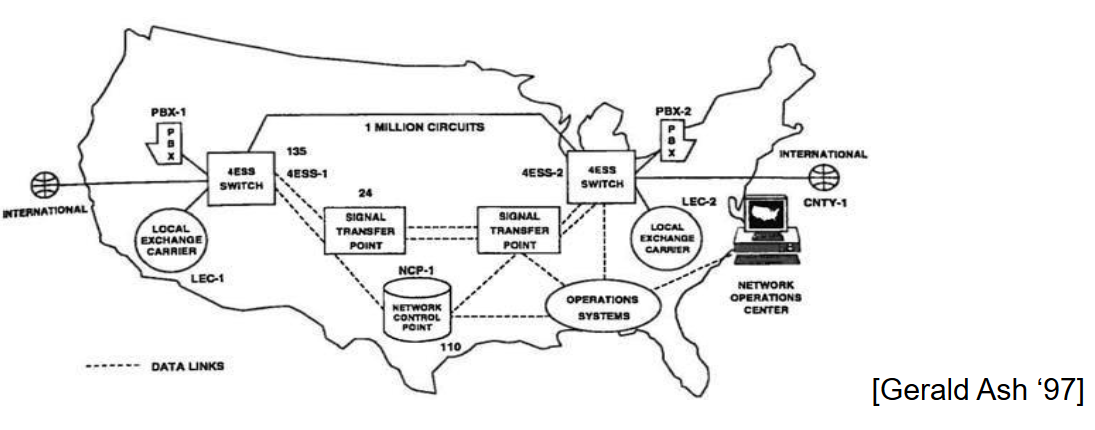

In [ ]:
# You can find a similar image as per the images you have in the metadata.
# In this case, you have a table (picked from the same document source) and you would like to find similar tables in the document.
image_query_path = "/content/MM-RAG/PDF Data/internet_image.png"

# Print a message indicating the input image
print("***Input image from user:***")

# Display the input image
Image.load_from_file(image_query_path)


 **** Result: ***** 



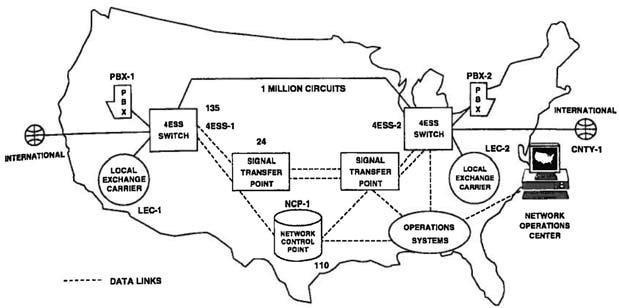

In [ ]:
# Search for Similar Images Based on Input Image and Image Embedding

matching_results_image = get_similar_image_from_query(
    text_metadata_df,
    image_metadata_df,
    query=query,  # Use query text for additional filtering (optional)
    column_name="mm_embedding_from_img_only",  # Use image embedding for similarity calculation
    image_emb=True,
    image_query_path=image_query_path,  # Use input image for similarity calculation
    top_n=3,  # Retrieve top 3 matching images
    embedding_size=1408,  # Use embedding size of 1408
)

print("\n **** Result: ***** \n")

# Display the Top Matching Image
display(
    matching_results_image[0]["image_object"]
)  # Display the top matching image object (Pillow Image)

It did find a similar-looking image.

In [ ]:
# Display citation details for the top matching image
print_text_to_image_citation(
    matching_results_image, print_top=True
)  # Print citation details for the top matching image

Citation 1: Matched image path, page number and page text: 

score:  0.89
file_name:  MM802_IntroductionPDF_edited.pdf
path:  images/MM802_IntroductionPDF_edited.pdf_image_11_0_58.jpeg
page number:  12
page text:   
 
Computer Networks and the internet 
Circuit-switching vs Packet-switching 
Telephone Networks 
Hierarchical: edge is simple, core is sophisticated. e.g., the AT&T network has: 
[Gerald Ash 97] 

image description:   The image shows a telecommunications network. It consists of two local exchange carriers (LEC), two private branch exchanges (PBX), and a network operations center (NOC). The LECs are connected to each other by a 1 million circuit switch. The PBXs are connected to the LECs by 4ESS switches. The NOC is connected to the LECs and PBXs by data links. The network is used to provide voice and data services to customers.
